## DSCC202-402 Data Science at Scale Final Project
### Tracking Tweet sentiment at scale using a pretrained transformer (classifier)
<p>Consider the following illustration of the end to end system that you will be building.  Each student should do their own work.  The project will demonstrate your understanding of Spark Streaming, the medalion data architecture using Delta Lake, Spark Inference at Scale using an MLflow packaged model as well as Exploritory Data Analysis and System Tracking and Monitoring.</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/pipeline.drawio.png">

<p>
You will be pulling an updated copy of the course GitHub repositiory: <a href="https://github.com/lpalum/dscc202-402-spring2024">The Repo</a>.  If you are unclear on how to pull an updated copy using the GitHub command line, the following <a href="https://techwritingmatters.com/how-to-update-your-forked-repository-on-github">document</a> is helpful.  Be sure to add the professors and TAs as collaborators on your project. 

- lpalum@gmail.com GitHub ID: lpalum
- ajay.anand@rochester.edu GitHub ID: ajayan12
- divyamunot1999@gmail.com GitHub ID: divyamunot
- ylong6@u.Rochester.edu GitHub ID: NinaLong2077

Once you have updates your fork of the repository you should see the following template project that is resident in the final_project directory.
</p>

<img src="https://data-science-at-scale.s3.amazonaws.com/images/notebooks.drawio.png">

<p>
You can then pull your project into the Databrick Workspace using the <a href="https://www.databricks.training/step-by-step/importing-courseware-from-github/index.html">Repos</a> feature.
Each student is expected to submit the URL of their project on GitHub with their code checked in on the main/master branch.  This illustration highlights the branching scheme that you may use to work on your code in steps and then merge your submission into your master branch before submitting.
</p>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/github.drawio.png">
<p>
Work your way through this notebook which will give you the steps required to submit a complete and compliant project.  The following illustration and associated data dictionary specifies the transformations and data that you are to generate for each step in the medallion pipeline.
</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/dataframes.drawio.png">

#### Bronze Data - raw ingest
- date - string in the source json
- user - string in the source json
- text - tweet string in the source json
- sentiment - the given sentiment of the text as determined by an unknown model that is provided in the source json
- source_file - the path of the source json file the this row of data was read from
- processing_time - a timestamp of when you read this row from the source json

#### Silver Data - Bronze Preprocessing
- timestamp - convert date string in the bronze data to a timestamp
- mention - every @username mentioned in the text string in the bronze data gets a row in this silver data table.
- cleaned_text - the bronze text data with the mentions (@username) removed.
- sentiment - the given sentiment that was associated with the text in the bronze table.

#### Gold Data - Silver Table Inference
- timestamp - the timestamp from the silver data table rows
- mention - the mention from the silver data table rows
- cleaned_text - the cleaned_text from the silver data table rows
- sentiment - the given sentiment from the silver data table rows
- predicted_score - score out of 100 from the Hugging Face Sentiment Transformer
- predicted_sentiment - string representation of the sentiment
- sentiment_id - 0 for negative and 1 for postive associated with the given sentiment
- predicted_sentiment_id - 0 for negative and 1 for positive assocaited with the Hugging Face Sentiment Transformer

#### Application Data - Gold Table Aggregation
- min_timestamp - the oldest timestamp on a given mention (@username)
- max_timestamp - the newest timestamp on a given mention (@username)
- mention - the user (@username) that this row pertains to.
- negative - total negative tweets directed at this mention (@username)
- neutral - total neutral tweets directed at this mention (@username)
- positive - total positive tweets directed at this mention (@username)

When you are designing your approach, one of the main decisions that you will need to make is how you are going to orchestrate the streaming data processing in your pipeline.  There are several valid approaches.  First, you may choose to start the bronze_stream and let it complete (read and append all of the source data) before preceeding and starting up the silver_stream.  This approach has latency associated with it but it will allow your code to proceed in a linear fashion and process all the data by the end of your notebook execution.  Another potential approach is to start all the streams and have a "watch" method to determine when the pipeline has processed sufficient or all of the source data before stopping and displaying results.  Both of these approaches are valid and have different implications on how you will trigger your steams and how you will gate the execution of your pipeline.  Think through how you want to proceed and ask questions if you need guidance. The following references may be helpful:
- [Spark Structured Streaming Programming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html)
- [Databricks Autoloader - Cloudfiles](https://docs.databricks.com/en/ingestion/auto-loader/index.html)

### Be sure that your project runs end to end when *Run all* is executued on this notebook! (15 Points out of 60)

In [0]:
%run ./includes/includes

Variable Name,Value,Description
TWEET_BUCKET_NAME,voc-75-databricks-data,AWS S3 Bucket Name where the tweets are coming into your system.
TWEET_BUCKET_URL,https://voc-75-databricks-data.s3.amazonaws.com/,AWS S3 Bucket URL where the tweets are coming into your system.
TWEET_SOURCE_PATH,s3a://voc-75-databricks-data/voc_volume/,AWS S3 Path where the tweets are coming into your system.
USER_DIR,/tmp/labuser104917-3042539/,Path to the local storage (dbfs) for your project.
BRONZE_CHECKPOINT,/tmp/labuser104917-3042539/bronze.checkpoint,Store your Bronze Checkpoint data here.
BRONZE_DELTA,/tmp/labuser104917-3042539/bronze.delta,Store your Bronze Delta Table here.
SILVER_CHECKPOINT,/tmp/labuser104917-3042539/silver.checkpoint,Store your Silver Checkpoint data here.
SILVER_DELTA,/tmp/labuser104917-3042539/silver.delta,Store your Silver Delta Table here.
GOLD_CHECKPOINT,/tmp/labuser104917-3042539/gold.checkpoint,Store your Gold Checkpoint data here.
GOLD_DELTA,/tmp/labuser104917-3042539/gold.delta,Store your Gold Delta Table here.


the includes are included


In [0]:
"""
dbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])
if (getArgument("clear_previous_run") == "Yes"):
    clear_previous_run()
    print("Cleared all previous data.")

dbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])
if (getArgument("stop_streams") == "Yes"):
    stop_all_streams()
    print("Stopped all active streams.")
"""

Out[6]: '\ndbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])\nif (getArgument("clear_previous_run") == "Yes"):\n    clear_previous_run()\n    print("Cleared all previous data.")\n\ndbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])\nif (getArgument("stop_streams") == "Yes"):\n    stop_all_streams()\n    print("Stopped all active streams.")\n'

In [0]:
"""
Adding a widget to the notebook to control the clearing of a previous run.
or stopping the active streams using routines defined in the utilities notebook
"""
dbutils.widgets.removeAll()
"""
dbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])
if (getArgument("clear_previous_run") == "Yes"):
    clear_previous_run()
    print("Cleared all previous data.")

dbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])
if (getArgument("stop_streams") == "Yes"):
    stop_all_streams()
    print("Stopped all active streams.")

from delta import *
dbutils.widgets.dropdown("optimize_tables", "No", ["No","Yes"])
if (getArgument("optimize_tables") == "Yes"):
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, BRONZE_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, SILVER_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, GOLD_DELTA).optimize().executeCompaction()
    print("Optimized all of the Delta Tables")
    """

Out[7]: '\ndbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])\nif (getArgument("clear_previous_run") == "Yes"):\n    clear_previous_run()\n    print("Cleared all previous data.")\n\ndbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])\nif (getArgument("stop_streams") == "Yes"):\n    stop_all_streams()\n    print("Stopped all active streams.")\n\nfrom delta import *\ndbutils.widgets.dropdown("optimize_tables", "No", ["No","Yes"])\nif (getArgument("optimize_tables") == "Yes"):\n    # Suck up those small files that we have been appending.\n    DeltaTable.forPath(spark, BRONZE_DELTA).optimize().executeCompaction()\n    # Suck up those small files that we have been appending.\n    DeltaTable.forPath(spark, SILVER_DELTA).optimize().executeCompaction()\n    # Suck up those small files that we have been appending.\n    DeltaTable.forPath(spark, GOLD_DELTA).optimize().executeCompaction()\n    print("Optimized all of the Delta Tables")\n    '

## 1.0 Import your libraries here...
- Are your shuffle partitions consistent with your cluster and your workload?
- Do you have the necessary libraries to perform the required operations in the pipeline/application?

In [0]:
# Import necessary libraries from PySpark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, TimestampType
from pyspark.sql.functions import col, expr, to_timestamp, explode_outer, regexp_replace, split, current_timestamp, input_file_name, when, desc
from pyspark.sql.streaming import DataStreamReader
from delta import DeltaTable
from pyspark.sql import functions as F

# Import machine learning and metrics calculation libraries
import mlflow
import mlflow.pyfunc
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Import data manipulation and visualization libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import standard libraries
import time

## 2.0 Use the utility functions to ...
- Read the source file directory listing
- Count the source files (how many are there?)
- print the contents of one of the files

In [0]:
# Reading the files from the source
source_files_df = get_source_listing_df()

In [0]:
# Counting the number of files
num_files = len(source_files_df)
print(f"Total number of source files: {num_files}")

Total number of source files: 200001


In [0]:
# Displaying contents of the first file
first_file = source_files_df.iloc[0]['File Name']
file_contents = show_s3_file_contents(first_file)
print(file_contents)

b'{"date": "Mon Apr 06 22:19:45 PDT 2009", "user": "_TheSpecialOne_", "text": "@switchfoot http://twitpic.com/2y1zl - Awww, that\'s a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "sentiment": "negative"}'


## 3.0 Transform the Raw Data to Bronze Data using a stream
- define the schema for the raw data
- setup a read stream using cloudfiles and the source data format
- setup a write stream using cloudfiles to append to the bronze delta table
- enforce schema
- allow a new schema to be merged into the bronze delta table
- Use the defined BRONZE_CHECKPOINT and BRONZE_DELTA paths defines in the includes
- name your raw to bronze stream as bronze_stream
- transform the raw data to the bronze data using the data definition at the top of the notebook

In [0]:
raw_data_schema = StructType([
    StructField("date", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True),
    StructField("sentiment", StringType(), True)
])


In [0]:
bronze_stream_df = (
    spark.readStream
    .format("cloudFiles")
    .option("cloudFiles.format", "json")
    .schema(raw_data_schema)
    .load(TWEET_SOURCE_PATH)
)

In [0]:
# Adding source file and processing time columns
bronze_stream_df = bronze_stream_df.withColumn("source_file", input_file_name()).withColumn("processing_time", current_timestamp())


In [0]:
# Writing stream to Bronze Delta table
bronze_stream = (
    bronze_stream_df
    .writeStream
    .format("delta")
    .outputMode("append")
    .option("checkpointLocation", BRONZE_CHECKPOINT)
    .option("mergeSchema", "true")
    .start(BRONZE_DELTA)
)

In [0]:
#bronze_stream.stop()

In [0]:
#bronze_df = spark.read.format("delta").load(BRONZE_DELTA)

#count = bronze_df.count()
#print(f"Number of rows in Bronze table: {count}")


In [0]:

# Periodically checking the stream status
#while bronze_stream.isActive:
#    print(bronze_stream.status)
#    time.sleep(30)


## 4.0 Bronze Data Exploratory Data Analysis
- How many tweets are captured in your Bronze Table?
- Are there any columns that contain Nan or Null values?  If so how many and what will you do in your silver transforms to address this?
- Count the number of tweets by each unique user handle and sort the data by descending count.
- How many tweets have at least one mention (@) how many tweet have no mentions (@)
- Plot a bar chart that shows the top 20 tweeters (users)


In [0]:
bronze_data = spark.read.format("delta").load(BRONZE_DELTA)

In [0]:
#Counting total number of tweets in the bronze table
bronze_tweet_count = bronze_data.count()
print("Number of tweets in Bronze Table:", bronze_tweet_count)

Number of tweets in Bronze Table: 200000


In [0]:
# Checking for columns containing NaN or null values
null_columns = [column for column in bronze_data.columns if bronze_data.where(col(column).isNull()).count() > 0]
if null_columns:
    print("Columns with NaN or Null values:", null_columns)
    for column in null_columns:
        null_count = bronze_data.where(col(column).isNull()).count()
        print("Null count in column '{}': {}".format(column, null_count))
else:
    print("No columns contain NaN or Null values.")


No columns contain NaN or Null values.


In [0]:
#Counting the number of tweets by each unique user handle and sorting the data by descending count
user_tweet_counts = bronze_data.groupBy("user").count().orderBy(desc("count"))
user_tweet_counts.show()

+---------------+-----+
|           user|count|
+---------------+-----+
|       tweetpet|  310|
|     nuttychris|  129|
|      iHomeTech|   81|
|       tsarnick|   77|
| Hollywood_Trey|   71|
|  divxdownloads|   68|
|      lesley007|   65|
|  redrobinrockn|   58|
|    MissxMarisa|   57|
|     SarahSaner|   56|
|     sebby_peek|   55|
|        kasey79|   54|
|torilovesbradie|   51|
|    whitsundays|   51|
|         keza34|   49|
| MiDesfileNegro|   48|
|        Dogbook|   47|
|   TraceyHewins|   46|
|    effingcards|   43|
|         Djalfy|   43|
+---------------+-----+
only showing top 20 rows



In [0]:
# Tweets statistics
tweets_with_mentions = bronze_data.filter(col("text").contains("@")).count()
tweets_without_mentions = bronze_tweet_count - tweets_with_mentions
print("Number of tweets with at least one mention (@):", tweets_with_mentions)
print("Number of tweets with no mentions (@):", tweets_without_mentions)

Number of tweets with at least one mention (@): 93817
Number of tweets with no mentions (@): 106183


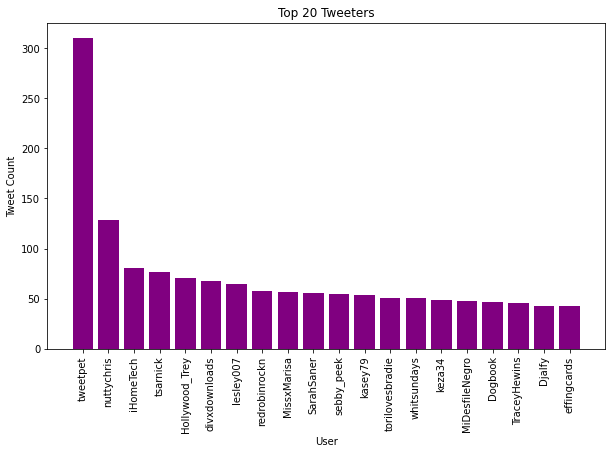

In [0]:
# Bar chart that shows the top 20 tweeters
top_20_tweeters = user_tweet_counts.limit(20)
top_20_tweeters_pd = top_20_tweeters.toPandas()

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(top_20_tweeters_pd["user"], top_20_tweeters_pd["count"], color='purple')
plt.xlabel("User")
plt.ylabel("Tweet Count")
plt.title("Top 20 Tweeters")
plt.xticks(rotation=90)
plt.show()

## 5.0 Transform the Bronze Data to Silver Data using a stream
- setup a read stream on your bronze delta table
- setup a write stream to append to the silver delta table
- Use the defined SILVER_CHECKPOINT and SILVER_DELTA paths in the includes
- name your bronze to silver stream as silver_stream
- transform the bronze data to the silver data using the data definition at the top of the notebook

In [0]:
"""
dbutils.fs.rm(SILVER_DELTA, True)
dbutils.fs.rm(SILVER_CHECKPOINT, True)

# Create the Silver Delta and checkpoint directories again
dbutils.fs.mkdirs(SILVER_DELTA)
dbutils.fs.mkdirs(SILVER_CHECKPOINT)
"""

Out[25]: '\ndbutils.fs.rm(SILVER_DELTA, True)\ndbutils.fs.rm(SILVER_CHECKPOINT, True)\n\n# Create the Silver Delta and checkpoint directories again\ndbutils.fs.mkdirs(SILVER_DELTA)\ndbutils.fs.mkdirs(SILVER_CHECKPOINT)\n'

In [0]:
"""
# Define the Silver data schema
silver_data_schema = StructType([
    StructField("timestamp", TimestampType(), True),
    StructField("mention", StringType(), True),
    StructField("cleaned_text", StringType(), True),
    StructField("sentiment", StringType(), True)
])
"""

Out[26]: '\n# Define the Silver data schema\nsilver_data_schema = StructType([\n    StructField("timestamp", TimestampType(), True),\n    StructField("mention", StringType(), True),\n    StructField("cleaned_text", StringType(), True),\n    StructField("sentiment", StringType(), True)\n])\n'

In [0]:
bronze_df = (
    spark.readStream
    .format("delta")
    .option("path", BRONZE_DELTA)
    .load()
)

In [0]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [0]:
date_format = "EEE MMM dd HH:mm:ss z yyyy"

silver_mid_df = bronze_df.select(
    to_timestamp(col("date"), date_format).alias("timestamp"),
    expr("explode_outer(split(text, ' ')) as word"),
    regexp_replace(col("text"), "@\\w+", "").alias("cleaned_text"),
    col("sentiment")
).where(col("word").rlike("^@\\w+"))

# Transforming to have rows for each mention specifically
silver_df = silver_mid_df.select(
    "timestamp",
    expr("substring(word, 2) as mention"),  # Removing '@' from the mention
    "cleaned_text",
    "sentiment"
)


In [0]:
# Writing stream to Silver Delta table
silver_stream = (
    silver_df
    .writeStream
    .format("delta")
    .outputMode("append")
    .option("checkpointLocation", SILVER_CHECKPOINT)
    .trigger(processingTime='4 minutes')
    .start(SILVER_DELTA)
)

In [0]:
#silver_stream.stop()

In [0]:

silver_df = spark.read.format("delta").load(SILVER_DELTA)

count = silver_df.count()
print(f"Number of rows in SILVER table: {count}")


Number of rows in SILVER table: 97417


In [0]:
"""
# Periodically checking the stream status
import time
while silver_stream.isActive:
    print(silver_stream.status)
    time.sleep(20)
 """

Out[36]: '\n# Periodically checking the stream status\nimport time\nwhile silver_stream.isActive:\n    print(silver_stream.status)\n    time.sleep(20)\n '

In [0]:
#silver_data = spark.read.format("delta").load(SILVER_DELTA)
#display(silver_data)

## 6.0 Transform the Silver Data to Gold Data using a stream
- setup a read stream on your silver delta table
- setup a write stream to append to the gold delta table
- Use the defined GOLD_CHECKPOINT and GOLD_DELTA paths defines in the includes
- name your silver to gold stream as gold_stream
- transform the silver data to the gold data using the data definition at the top of the notebook
- Load the pretrained transformer sentiment classifier from the MODEL_NAME at the production level from the MLflow registry
- Use a spark UDF to parallelize the inference across your silver data

In [0]:
# Reading streaming data from the Silver Delta table
silver_df = (
    spark.readStream
    .format("delta")
    .load(SILVER_DELTA) 
)


In [0]:
# Loading the model as a Spark UDF from MLflow
model_uri = f"models:/{MODEL_NAME}/Production"
sentiment_analysis_udf = mlflow.pyfunc.spark_udf(spark, model_uri)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-b99f41e3-fc6f-4fb9-abd4-2a29429515bf/lib/python3.9/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


2024/05/12 03:44:48 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/05/12 03:44:52 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.12.2, required: mlflow==2.11.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/05/12 03:44:52 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.


2024/05/12 03:44:52 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


In [0]:
gold_stream_df = silver_df.select(
    col("timestamp"),
    col("mention"),
    col("cleaned_text"),
    col("sentiment"),
    when(sentiment_analysis_udf(col("cleaned_text")).getField("label") == "NEU", "NEG")
        .otherwise(sentiment_analysis_udf(col("cleaned_text")).getField("label"))
        .alias("predicted_sentiment"),
    (sentiment_analysis_udf(col("cleaned_text")).getField("score") * 100)
        .alias("predicted_score"),
    when(sentiment_analysis_udf(col("cleaned_text")).getField("label") == "POS", 1)   #The sentiments with a label POS is given value 1 that is considered poitive, while the NEU and NEG, neutral and negative are considered as negative. But the labels are maintained to keep count of them only sentiment values are afftected
        .otherwise(0)
        .alias("predicted_sentiment_id"),
    (col("sentiment") == "positive").cast("integer").alias("sentiment_id")
)


In [0]:
# Writing stream to Gold Delta table
gold_stream = (
    gold_stream_df
    .writeStream
    .format("delta")
    .outputMode("append")
    .option("checkpointLocation", GOLD_CHECKPOINT)
    .trigger(processingTime='30 seconds')
    .start(GOLD_DELTA)
)

In [0]:
#gold_stream.stop()

In [0]:

gold_data = spark.read.format("delta").load(GOLD_DELTA)

count = gold_data.count()
print(f"Number of rows in Gold table: {count}")


Number of rows in Gold table: 97417


In [0]:
""""
# Periodically checking the stream status
import time
while gold_stream.isActive:
    print(gold_stream.status)
    time.sleep(300)
    """

Out[42]: '"\n# Periodically checking the stream status\nimport time\nwhile gold_stream.isActive:\n    print(gold_stream.status)\n    time.sleep(300)\n    '

In [0]:
#gold_data = spark.read.format("delta").load(GOLD_DELTA)
#display(gold_data)

## 7.0 Capture the accuracy metrics from the gold table in MLflow
Store the following in an MLflow experiment run:
- Store the precision, recall, and F1-score as MLflow metrics
- Store an image of the confusion matrix as an MLflow artifact
- Store the mdoel name and the MLflow version that was used as an MLflow parameters
- Store the version of the Delta Table (input-silver) as an MLflow parameter

In [0]:
gold_data = spark.read.format("delta").load(GOLD_DELTA)
pdf = gold_data.select("predicted_sentiment_id", "sentiment_id").toPandas()


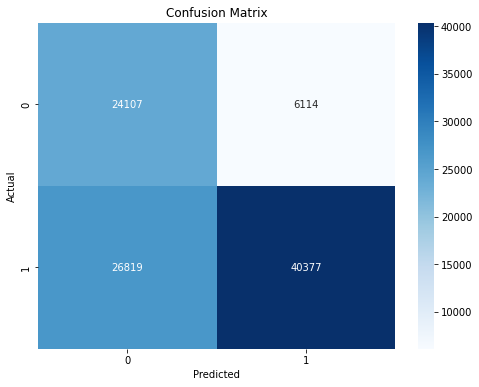

In [0]:
precision = precision_score(pdf['sentiment_id'], pdf['predicted_sentiment_id'], average='binary')
recall = recall_score(pdf['sentiment_id'], pdf['predicted_sentiment_id'], average='binary')
f1 = f1_score(pdf['sentiment_id'], pdf['predicted_sentiment_id'], average='binary')

# Generating confusion matrix
cm = confusion_matrix(pdf['sentiment_id'], pdf['predicted_sentiment_id'])

# Ploting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
confusion_matrix_path = "/dbfs/tmp/confusion_matrix.png"  
plt.savefig(confusion_matrix_path)

# Log to MLflow
with mlflow.start_run():
    # Log metrics
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_artifact(confusion_matrix_path)

    # Log the confusion matrix as an artifact
    mlflow.log_artifact(confusion_matrix_path)

    # Log the MLflow version and model name
    mlflow.log_param("mlflow_version", mlflow.__version__)
    mlflow.log_param("model_name", MODEL_NAME)  

    # Log the version of the Silver Delta Table
    delta_table = DeltaTable.forPath(spark, SILVER_DELTA)
    version = delta_table.history(1).collect()[0]['version'] 
    mlflow.log_param("silver_delta_table_version", str(version))


## 8.0 Application Data Processing and Visualization
- How many mentions are there in the gold data total?
- Count the number of neutral, positive and negative tweets for each mention in new columns
- Capture the total for each mention in a new column
- Sort the mention count totals in descending order
- Plot a bar chart of the top 20 mentions with positive sentiment (the people who are in favor)
- Plot a bar chart of the top 20 mentions with negative sentiment (the people who are the vilians)

You may want to use the "Loop Application" widget to control whether you repeateded display the latest plots while the data comes in from your streams before moving on to the next section and cleaning up your run.

*note: A mention is a specific twitter user that has been "mentioned" in a tweet with an @user reference.

In [0]:
# Remove any existing widgets
#dbutils.widgets.removeAll()

# Create a dropdown widget to control the loop
#dbutils.widgets.dropdown("Update Plots", "Yes", ["Yes", "No"])


In [0]:
def update_plots():
    gold_df = spark.read.format("delta").load(GOLD_DELTA)
    agg_df = gold_df.groupBy("mention").agg(
        F.min("timestamp").alias("min_timestamp"),
        F.max("timestamp").alias("max_timestamp"),
        F.sum(F.when(F.col("predicted_sentiment") == "NEG", 1).otherwise(0)).alias("negative"),
        F.sum(F.when(F.col("predicted_sentiment") == "NEU", 1).otherwise(0)).alias("neutral"),
        F.sum(F.when(F.col("predicted_sentiment") == "POS", 1).otherwise(0)).alias("positive")
    ).withColumn("total_mentions", F.col("negative") + F.col("neutral") + F.col("positive"))
    sorted_df = agg_df.orderBy(F.col("total_mentions").desc()).toPandas()

    total_mentions = agg_df.count()
    print(f"Total number of unique mentions: {total_mentions}")

    # Create and return figures
    fig1, ax1 = plt.subplots(figsize=(12, 8))
    sns.barplot(x="positive", y="mention", data=sorted_df.head(20), palette="viridis", ax=ax1)
    ax1.set_title("Top 20 Mentions with Positive Sentiment")
    ax1.set_xlabel("Count of Positive Tweets")
    ax1.set_ylabel("Mention")

    fig2, ax2 = plt.subplots(figsize=(12, 8))
    sns.barplot(x="negative", y="mention", data=sorted_df.head(20), palette="inferno", ax=ax2)
    ax2.set_title("Top 20 Mentions with Negative Sentiment")
    ax2.set_xlabel("Count of Negative Tweets")
    ax2.set_ylabel("Mention")

    return fig1, fig2


Total number of unique mentions: 65228


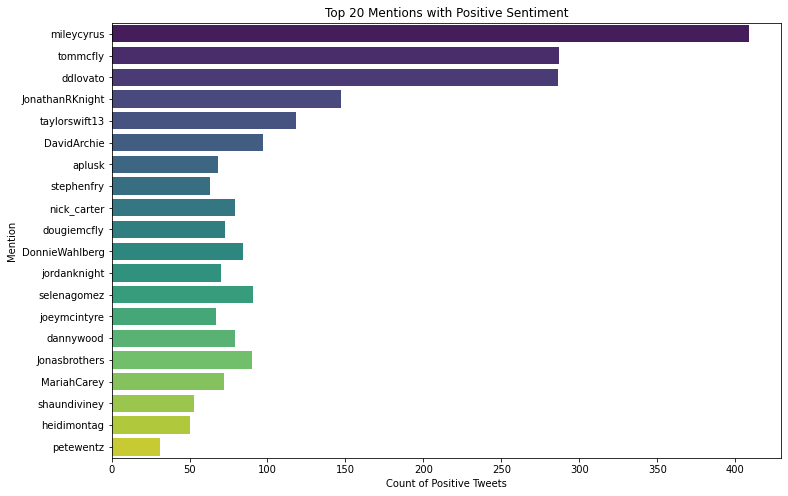

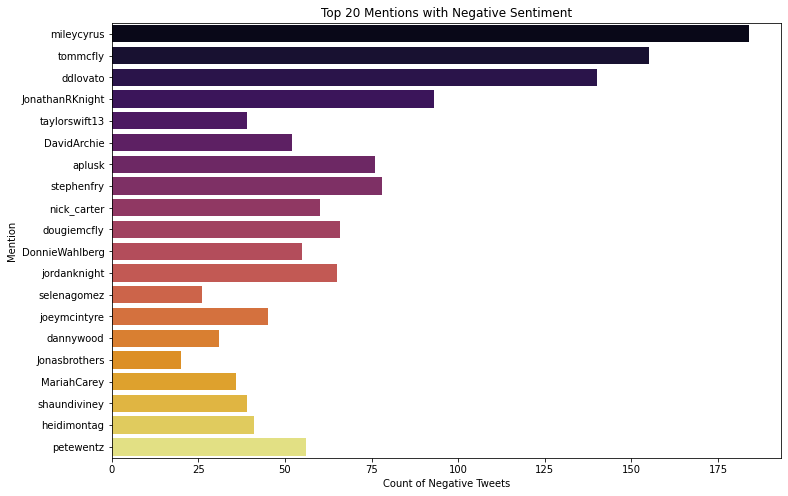

In [0]:
fig1, fig2 = update_plots()
plt.show(fig1)
plt.show(fig2)

In [0]:
"""

while True:
    if dbutils.widgets.get("Update Plots") == "Yes":
        fig1, fig2 = update_plots()
        
        plt.show(fig1)
        plt.close(fig1)  
        
        plt.show(fig2)
        plt.close(fig2)  
        
        time.sleep(30)
    else:
        time.sleep(120)
        continue
"""

In [0]:
"""
top_mentions_pd = sorted_df.toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(x="positive", y="mention", data=top_mentions_pd.head(20))
plt.title("Top 20 Mentions with Positive Sentiment")
plt.xlabel("Count of Positive Tweets")
plt.ylabel("Mention")
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x="negative", y="mention", data=top_mentions_pd.head(20))
plt.title("Top 20 Mentions with Negative Sentiment")
plt.xlabel("Count of Negative Tweets")
plt.ylabel("Mention")
plt.show()
"""

## 9.0 Clean up and completion of your pipeline
- using the utilities what streams are running? If any.
- Stop all active streams
- print out the elapsed time of your notebook.

In [0]:
from pyspark.sql import SparkSession

def stop_all_streams(spark: SparkSession) -> bool:
    """
    Stops all active streams in the given Spark session.
    Returns True if all streams were stopped successfully, False otherwise.
    """
    stopped = True
    for stream in spark.streams.active:
        print(f"Stopping stream: {stream.name}")
        stream.stop()
        if stream.isActive:
            stopped = False
    return stopped

def print_active_streams(spark: SparkSession):
    """
    Prints all currently active streams.
    """
    active_streams = spark.streams.active
    if active_streams:
        print("Active streams:")
        for stream in active_streams:
            print(f"- {stream.name}")
    else:
        print("No active streams.")


In [0]:
print_active_streams(spark)  
if stop_all_streams(spark):
    print("All streams have been stopped successfully.")
else:
    print("Failed to stop one or more streams.")

print_active_streams(spark) 


No active streams.
All streams have been stopped successfully.
No active streams.


In [0]:
# Get the notebooks ending time note START_TIME was established in the include file when the notebook started.
END_TIME = time.time()

In [0]:
total_time = END_TIME - START_TIME

# Print the total time taken.
print(f"{total_time} seconds")

907.3938529491425 seconds


## 10.0 How Optimized is your Spark Application (Grad Students Only)
Graduate students (registered for the DSCC-402 section of the course) are required to do this section.  This is a written analysis using the Spark UI (link to screen shots) that support your analysis of your pipelines execution and what is driving its performance.
Recall that Spark Optimization has 5 significant dimensions of considertation:
- Spill: write to executor disk due to lack of memory
- Skew: imbalance in partition size
- Shuffle: network io moving data between executors (wide transforms)
- Storage: inefficiency due to disk storage format (small files, location)
- Serialization: distribution of code segments across the cluster

Comment on each of the dimentions of performance and how your impelementation is or is not being affected.  Use specific information in the Spark UI to support your description.  

Note: you can take sreenshots of the Spark UI from your project runs in databricks and then link to those pictures by storing them as a publicly accessible file on your cloud drive (google, one drive, etc.)

References:
- [Spark UI Reference Reference](https://spark.apache.org/docs/latest/web-ui.html#web-ui)
- [Spark UI Simulator](https://www.databricks.training/spark-ui-simulator/index.html)

For a random given stage have 37 tasks(in the screenshot), we canobserve the following things, 
https://drive.google.com/file/d/1C8j6qgaiIfDgHPhLBhIAdNt9W-3Z31_w/view?usp=sharing
https://drive.google.com/file/d/1_duxk31VyL1WBZiS_jesfwP8pL7S1mp0/view?usp=drive_link


##### Spill 
  -  Peak Execution Memory shows all tasks are consistently using 64.3 MiB. There is no indication of memory spill to disk which is a positive sign indicating that memory management within your tasks is efficient.
  - Implication: This is an indicator of efficient memory management. It suggests that the current memory settings are adequate for the workload, minimizing the need for tasks to spill data to disk, which can significantly slow down performance.
#####  Skew
  -  The input size per record across tasks is quite consistent (around 78 KiB to 86.4 KiB), suggesting that there is minimal skew in data partitioning. This uniformity helps in maintaining balanced workloads across tasks.
  - Implication: The slight variation in shuffle write sizes could indicate minor skew in data distribution across partitions. However, the differences are not substantial, suggesting that any skew is not severely impacting performance.
##### Shuffle
  - The shuffle write size is fairly consistent, hovering around 110.8 KiB to 116.2 KiB, with a slight variance in shuffle write time (18 ms to 33 ms). This indicates efficient handling of shuffle operations but points to a potential area for optimization to reduce write times. While there is data being shuffled across nodes, it's not excessively large.
  - Implication: Moderate shuffle sizes are typically manageable but increasing data volume or complexity could lead to higher shuffle volumes, impacting network IO and overall job performance.



https://drive.google.com/file/d/1hd7yv2hkDECudLaJwQukC2QEkIKOvltU/view?usp=sharing


https://drive.google.com/file/d/1eLf4tCb4TC1TvInH4FQP4kyh1NzARUrP/view?usp=sharing

From the above two screen shots, we can see learn about the storage dimension(These were taken after the jobs were completed)

##### Storage 
- The Spark UI shows that a small amount of memory (27.0 KiB) is being used for caching RDDs related to Delta Table states. This implies efficient utilization of memory with minimal disk usage, as shown by "Disk Size: 0.0 B" for the cached data. It indicates that the data fits well within the allocated memory, preventing any need for spilling to disk.
- The total disk usage limit is far from being reached (463.9 GiB limit with only 38.5 MiB used), suggesting that the current workload is well within the hardware's capacity. So even when the processes in this code were running, there would have been sufficient memory.
- There is a noticeable amount of data being read (91.5 MiB) and written (28.0 MiB) to the IO cache. This activity supports the performance by lessening the amount of data processing required directly from the external file system, shown by the 70.6 MiB read externally.
- The RDDs for Delta Table states are stored with "Disk Memory Serialized 1x Replicated" storage level. This means that the data is serialized, stored both in memory and on disk, and replicated once across the cluster for fault tolerance.
- Each of the RDDs associated with Delta Table states shows that all partitions (100% of them) are cached. This ensures quick access to these partitions during Spark jobs, reducing the time needed to fetch this data repeatedly from disk or rebuild it from other operations.
- Caching these partitions fully in memory aids in speeding up queries that access these tables frequently, as the data can be quickly retrieved from memory instead of being read from disk or recomputed.
- The minimal memory use for metadata (e.g., 10.6 MiB for metadata cache size) coupled with the cache hit ratio of 76% suggests that the metadata operations for Delta Tables are efficiently supporting the query operations, where most data needed is being served from cache rather than requiring fresh reads from storage.


https://drive.google.com/file/d/1W4c9WccYy61ptJ9M7szdRMlZqztFZjzX/view?usp=sharing

##### Serialisation
- This setting controls the number of objects serialized before Spark's serializer resets the object output stream. Resetting the object output stream clears any memory references it holds, preventing a memory leak and reducing the size of the serialized data that needs to be transmitted over the network.
- The default value is 100, meaning the output stream will reset after every 100 objects are serialized. This is a balanced choice that prevents excessive memory usage without resetting so frequently that it impacts performance adversely. 

